In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install fiona
!pip install rasterio
!pip install torchviz
!pip install albumentations

In [0]:
import sys
sys.path.append('/content/drive/My Drive/Weak_Learners_ML2020')

In [0]:
import scipy
import numpy as np
import seaborn as sns
import fiona
import rasterio
from shapely import geometry
from rasterio.mask import mask

def extractor(frame,points,size=7,normalize=True,labeling=False):
  '''
  The extractor fuction takes in three paramters:
  
    1. frame - The image to be subdevided. Resterio type file
    2. points - fiona collection file with coordinates of points
    3. size - size of the window
    4. data normalization - normolize the data boolean
    5. require labels if the data containes labels. Boolean
    
  Return:
  
    1. List of bathces with the give size
    2. List of coordinates
    3. List of labels
  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
  Example:
      frame = rasterio.open("pp_1_sat_modified1.tif")
      points = fiona.open("alltreepoints1.shp", "r")
      collection = extractor(frame,points,size=7)
  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   
  '''
  img = frame.read((5,3,2)).T.astype('uint32')
  if normalize:
    img = img/np.max(img)

  assert img.shape[1]>img.shape[2], "channles are in the right place!"+str(img.shape)
  map_tree_speices = {'е':0, 'б':1, 'п':2, "El'":0, "Bereza":1, "Pichta":2, "Sosna":3} 
  img_point,locations,labels = [],[],[]

  for p in range(len(points)):

        try:  
              point = np.array(frame.index(*points[p]['geometry']['coordinates']))
              box = img[(point[1]-size):point[1]+size,
                        (point[0]-size):point[0]+size,:].copy()
              if labeling:
                  labels.append(map_tree_speices[ points[p]['properties']['specie'] ]) 
              img_point.append(box)
              locations.append(point)
              del box
        except:
              print("None coordinate/close to edge")
  return img_point, locations, labels

In [0]:
import scipy
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import fiona
import rasterio
from shapely import geometry
from rasterio.mask import mask
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, confusion_matrix

# from extractor_helper import extractor

# CNN

In [0]:
import torch
import torch.nn as nn
import torch.utils.data as torch_data
from torchviz import make_dot, make_dot_from_trace
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensor

**Get data**

In [0]:
SIZE = 8

In [0]:
test2_img = rasterio.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test2/pp_2_sat_modified.tif")
test2_points = fiona.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test2/points_2_modified_Copy.shp", "r")

test3_img = rasterio.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test3/pp_3_sat_modified.tif")
test3_points = fiona.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test3/targets_Copy.shp", "r")

test4_img = rasterio.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test4/pp_4_sat_modified_spline.tif")
test4_points = fiona.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test4/modified_points_Copy.shp", "r")

In [9]:
patch2, coordinates2, labels2, = extractor(test2_img, test2_points, size=SIZE, normalize=True, labeling=True)
patch3, coordinates3, labels3, = extractor(test3_img, test3_points, size=SIZE, normalize=True, labeling=True)
patch4, coordinates4, labels4, = extractor(test4_img, test4_points, size=SIZE, normalize=True, labeling=True)

None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coord

In [10]:
# patch2,patch3, patch4 = np.array(patch2), np.array(patch3), np.array(patch4)
# labels2, labels3, labels4 = np.array(labels2), np.array(labels3), np.array(labels4)
# patch2, patch3, patch4 = np.moveaxis(patch2,3,1), np.moveaxis(patch3,3,1), np.moveaxis(patch4,3,1)

patch = np.concatenate((patch2, patch3, patch4),axis=0)
labels = np.concatenate((labels2,labels3,labels4),axis=0)
print(patch.shape)

(1012, 16, 16, 3)


In [0]:
augmentation_pipeline = A.Compose(
    [
        A.HorizontalFlip(p = 0.5), # apply horizontal flip to 50% of images
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomContrast(),
                A.RandomGamma(),
                A.RandomBrightness(),
                A.RandomRotate90(),
                A.Transpose(),
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
                A.Blur(blur_limit=3),
                A.OpticalDistortion(),
                A.GridDistortion(),
            ],
            p = 0.5
        ),
        
        ToTensor() # convert the image to PyTorch tensor
    ],
    p = 1
)

In [0]:
class TreesData():
  def __init__(self, X, y, aug_pipeline=None):
    super().__init__()
    # if is_train:
    #   self.X = torch.tensor(X, dtype=torch.float32)
    # else:
    self.X = X
    self.y = torch.tensor(y, dtype=torch.long)
    if aug_pipeline:
        self.aug_pipeline = aug_pipeline
    else:
        self.aug_pipeline = A.Compose([ToTensor()], p=1)
    
  def __len__(self):
    return self.X.shape[0]
  
  def __getitem__(self, idx):
    augmented = self.aug_pipeline(image = self.X[idx])['image']
    return augmented, self.y[idx]

In [14]:
# Data proportions
unique, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f'Label "{label}" has {count:3} instances, which is {count/len(labels):6.2%} of the total number of instances')

Label "0" has 518 instances, which is 51.19% of the total number of instances
Label "1" has 315 instances, which is 31.13% of the total number of instances
Label "2" has  42 instances, which is  4.15% of the total number of instances
Label "3" has 137 instances, which is 13.54% of the total number of instances


In [0]:
# We do stratified splitting to have balanced train and test set.
x_train, x_test, y_train, y_test = train_test_split(patch, labels, test_size=.3, shuffle=True, stratify=labels, random_state=42)

In [0]:
train_data = TreesData(x_train, y_train, augmentation_pipeline)
test_data = TreesData(x_test, y_test, augmentation_pipeline)

**Define model**

In [0]:
from math import ceil

In [0]:
LAST_LAYER_SIZE = ceil(ceil(SIZE*2/2)/2)

CNN = lambda: nn.Sequential(
  
  nn.Conv2d(3,64,2, padding=1),
  nn.MaxPool2d(2,2),
  nn.ReLU(),
  nn.Dropout(0.5),

  nn.Conv2d(64,128,2, padding=1),
  nn.MaxPool2d(2,2),
  nn.ReLU(),
  nn.Dropout(0.5),

  nn.Flatten(),
  nn.Linear(128*LAST_LAYER_SIZE*LAST_LAYER_SIZE, 4),
)

**Train model**

In [0]:
def train(epochs, net, criterion, optimizer,
          train_loader, val_loader, scheduler=None,
          verbose=True, save_dir=None):
  
  net.to(device)
  train_loss_history = []
  val_loss_history = []
  val_loss_not_improved = 0
  best_val_loss = 999
  for epoch in range(1,epochs+1):
    net.train()
    total_instances = 0
    matched = 0
    train_loss = 0
    for X, y in train_loader:
      X = X.to(device)
      y = y.to(device)
      pred = net(X)
      loss = criterion(pred, y)
      train_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_pred_arg = np.argmax(pred.cpu().detach(), axis=1)
      matched += (train_pred_arg == y.cpu().detach()).sum()
      total_instances += len(train_pred_arg)
    train_acc = matched.item()/total_instances
   
    net.eval()
    total_instances = 0
    matched = 0
    predicted_y = np.array([])
    predicted_y_percent = np.array([])
    true_y = np.array([])
    val_loss = 0
    for X, y in val_loader:
      X = X.to(device)
      y = y.to(device)
      val_pred = net(X)
      val_loss += criterion(val_pred, y).item()

      predicted_y_percent = np.concatenate((predicted_y_percent, val_pred.cpu().detach()), axis=None)
      predicted_y = np.concatenate((predicted_y, np.argmax(val_pred.cpu().detach(), axis=1)), axis=None)
      true_y = np.concatenate((true_y, y.cpu().detach()), axis=None)
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc = (predicted_y == true_y).sum()/len(true_y)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
  
    if scheduler is not None:
      schduler.step()
    
    if verbose:
      print('Epoch {:3}/{} || Loss:  Train {:.6f} | Validation {:.6f} || Accuracy: Train {:.2%} | Validation {:.2%} || F1-score {:.2f}'\
            .format(epoch, epochs, train_loss, val_loss, train_acc, val_acc, f1_score(true_y, predicted_y, average='macro')))
      
    if best_val_loss > val_loss:
      best_val_loss = val_loss
      val_loss_not_improved = 0
    else:
      val_loss_not_improved += 1

    if val_loss_not_improved == 25:
      break

  return predicted_y, predicted_y_percent, true_y, train_loss_history, val_loss_history

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = CNN()
weights = torch.tensor([1,1,5,1], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(net.parameters())
scheduler = None
train_loader = torch_data.DataLoader(train_data, batch_size=50, shuffle=True)
val_loader = torch_data.DataLoader(test_data, batch_size=10, shuffle=True)

print('\t\t\t=== MODEL ===\n\t\t\t=============')
print(net)

			=== MODEL ===
Sequential(
  (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Dropout(p=0.5, inplace=False)
  (8): Flatten()
  (9): Linear(in_features=2048, out_features=4, bias=True)
)


In [0]:
# GRAPH
# make_dot(net(train_data[:1][0]))

In [22]:
epochs = 500
predicted_y, predicted_y_percent, true_y, train_loss_history, val_loss_history = train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler)
predicted_y_percent = torch.softmax(torch.tensor(predicted_y_percent.reshape(-1, 4)), axis=1).detach().numpy()

Epoch   1/500 || Loss:  Train 1.284685 | Validation 1.303906 || Accuracy: Train 49.29% | Validation 51.32% || F1-score 0.20
Epoch   2/500 || Loss:  Train 1.225325 | Validation 1.214557 || Accuracy: Train 49.01% | Validation 50.99% || F1-score 0.17
Epoch   3/500 || Loss:  Train 1.162114 | Validation 1.151539 || Accuracy: Train 51.41% | Validation 54.28% || F1-score 0.31
Epoch   4/500 || Loss:  Train 1.083683 | Validation 1.059679 || Accuracy: Train 54.38% | Validation 41.78% || F1-score 0.34
Epoch   5/500 || Loss:  Train 1.047385 | Validation 1.056429 || Accuracy: Train 54.66% | Validation 38.16% || F1-score 0.34
Epoch   6/500 || Loss:  Train 1.041306 | Validation 1.025743 || Accuracy: Train 49.15% | Validation 42.76% || F1-score 0.37
Epoch   7/500 || Loss:  Train 1.004247 | Validation 0.970480 || Accuracy: Train 59.18% | Validation 54.93% || F1-score 0.39
Epoch   8/500 || Loss:  Train 1.001902 | Validation 0.975641 || Accuracy: Train 54.38% | Validation 44.41% || F1-score 0.40
Epoch   

**Evaluation**

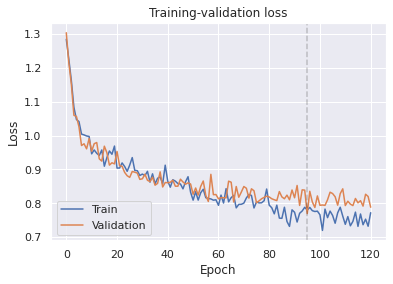

In [23]:
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.axvline(x=np.argmin(val_loss_history), color='black', alpha=0.2, linestyle='--')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training-validation loss')
plt.show()

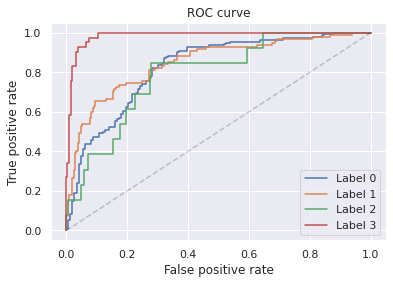

In [24]:
for i in range(4):
    fpr, tpr, thresholds = roc_curve((true_y == i).astype(np.int), predicted_y_percent[:, i])
    plt.plot(fpr, tpr, label='Label ' + str(i))
plt.plot([0, 1], [0, 1], color='black', alpha=0.2, linestyle='--')
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

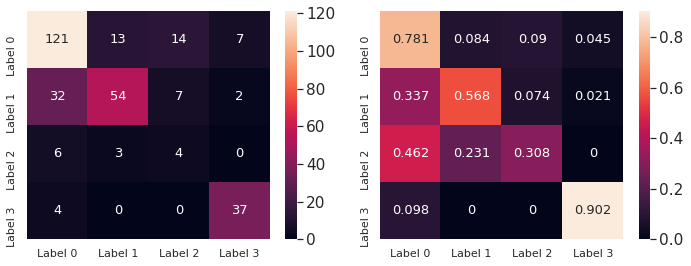

In [25]:
label_names = [f'Label {i}' for i in range(4)]
cm = confusion_matrix(true_y, predicted_y)
cm_df = pd.DataFrame(cm, columns=label_names, index=label_names)
cm_df_rel = pd.DataFrame(cm/cm.sum(1)[:, np.newaxis], columns=label_names, index=label_names)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_df, annot=True, annot_kws={"size": 13}, fmt='g', ax=axes[0])

sns.set(font_scale=1.4) # for label size
sns.heatmap(round(cm_df_rel, 3), annot=True, annot_kws={"size": 13}, fmt='g', ax=axes[1])

plt.tight_layout()
plt.show()

In [26]:
for label in label_names:
    print(f'Accuracy for {label} is {cm_df_rel[label][label]:.2%}')
print(f'Overall accuracy is {(predicted_y == true_y).sum()/len(true_y):.2%}')
print(f'Overall F1-score is {f1_score(true_y, predicted_y, average="macro"):.2f}')

Accuracy for Label 0 is 78.06%
Accuracy for Label 1 is 56.84%
Accuracy for Label 2 is 30.77%
Accuracy for Label 3 is 90.24%
Overall accuracy is 71.05%
Overall F1-score is 0.62
